In [4]:
import gzip
import itertools
import string

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pylab as pl
import nltk


from collections import Counter
from sklearn import svm
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer


%matplotlib inline

In [5]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet
from sklearn import metrics
from collections import defaultdict

In [6]:
df=pd.read_csv('train.csv')
df.head()

,polarity,title,text
0,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
1,2,Amazing!,This soundtrack is my favorite music of all ti...
2,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
3,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
4,2,an absolute masterpiece,I am quite sure any of you actually taking the...


In [7]:
text = df['text']

In [8]:
text.count()

1048575

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\doaatarek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
stop_words = stopwords.words('english')

In [11]:
wordnet_lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'[a-z]+')

def preprocess(document):
    document = document.lower() # Convert to lowercase
    words = tokenizer.tokenize(document) # Tokenize
    words = [w for w in words if not w in stop_words] # Removing stopwords
    # Lemmatizing
    for pos in [wordnet.NOUN, wordnet.VERB, wordnet.ADJ, wordnet.ADV]:
        words = [wordnet_lemmatizer.lemmatize(x, pos) for x in words]
    return " ".join(words)



In [12]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\doaatarek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
df['processed_text'] = df['text'].apply(preprocess)

In [14]:
df.head()

,polarity,title,text,processed_text
0,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...,read lot review say best game soundtrack figur...
1,2,Amazing!,This soundtrack is my favorite music of all ti...,soundtrack favorite music time hand intense sa...
2,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...,truly like soundtrack enjoy video game music p...
3,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine...",play game know divine music every single song ...
4,2,an absolute masterpiece,I am quite sure any of you actually taking the...,quite sure actually take time read play game l...


In [15]:
processed_text = df["processed_text"]

In [17]:
x_train, x_test, y_train, y_test = train_test_split(df.processed_text, df.polarity, random_state=0)

In [18]:
print("x_train shape: {}".format(x_train.shape), end='\n')
print("y_train shape: {}".format(y_train.shape), end='\n\n')
print("x_test shape: {}".format(x_test.shape), end='\n')
print("y_test shape: {}".format(y_test.shape), end='\n\n')

x_train shape: (786431,)
y_train shape: (786431,)

x_test shape: (262144,)
y_test shape: (262144,)



In [20]:
y_train

298025    2
742155    1
603940    2
801012    2
112780    1
         ..
963395    2
117952    2
435829    2
305711    2
985772    1
Name: polarity, Length: 786431, dtype: int64

In [21]:
# Fitting and transforming the training data to a document-term matrix using TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(x_train)
print("Number of features : %d \n" %len(tfidf.get_feature_names())) #1722
print("Show some feature names : \n", tfidf.get_feature_names()[::1000])

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

Number of features : 59470 

Show some feature names : 
 ['aa', 'agitator', 'andromeda', 'ascribe', 'balad', 'beowulf', 'bonfa', 'buggy', 'carthage', 'chirstmas', 'colour', 'convulted', 'cuisnart', 'degredation', 'diligently', 'dotcom', 'effie', 'epson', 'expresion', 'filmographies', 'freddy', 'genuises', 'grapefruit', 'happing', 'hinduism', 'hypothyroidism', 'inflame', 'isiah', 'justas', 'kriyananda', 'lexi', 'ludicrous', 'marr', 'merrill', 'moleskine', 'myung', 'nonpareil', 'onus', 'paltry', 'personaly', 'poision', 'pris', 'quede', 'recoverable', 'ret', 'royko', 'schiff', 'shall', 'skinless', 'spaciousness', 'stinkbomb', 'surpise', 'temerity', 'tinkerbell', 'trojan', 'unedited', 'val', 'waa', 'wiki', 'yemeni']


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [22]:
feature_names = np.array(tfidf.get_feature_names())
sorted_coef_index = lr.coef_[0].argsort()
print('\nTop 10 features with the smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with the largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))


Top 10 features with the smallest coefficients :
['waste' 'poorly' 'disappointment' 'disappoint' 'bore' 'awful' 'useless'
 'return' 'horrible' 'poor']

Top 10 features with the largest coefficients : 
['excellent' 'great' 'perfect' 'highly' 'amaze' 'favorite' 'love' 'best'
 'awesome' 'pleasantly']


In [28]:
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    #print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
    print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))

In [29]:
predictions = lr.predict(tfidf.transform(x_test))
modelEvaluation(predictions)


Accuracy on validation set: 0.8655

Classification report : 
               precision    recall  f1-score   support

           1       0.87      0.86      0.86    129363
           2       0.86      0.87      0.87    132781

    accuracy                           0.87    262144
   macro avg       0.87      0.87      0.87    262144
weighted avg       0.87      0.87      0.87    262144


Confusion Matrix : 
 [[111233  18130]
 [ 17135 115646]]


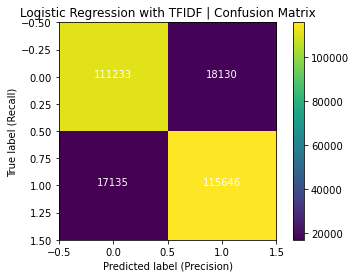

In [35]:

cfm = confusion_matrix(y_test, predictions)
plt.imshow(cfm, interpolation='nearest')

for i, j in itertools.product(range(cfm.shape[0]), range(cfm.shape[1])):
    plt.text(j, i, cfm[i, j],
             horizontalalignment="center",
             color="white")

plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('Logistic Regression with TFIDF | Confusion Matrix')
plt.colorbar();